# 定位到文件执行的文件夹下方

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
os.chdir("/content/drive/My Drive/LSTM")
!ls

BSrf1000.mat  Different_Models_Score_Pic  test1-analyse.ipynb  test2.ipynb
DATA	      IMG			  test1.ipynb	       train2.csv
DataProcess   LSTM.h5			  test2_all.ipynb      train.csv


# 总的头文件

In [0]:
import os
import numpy
import math
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# mat文件处理


## 此部分运行一次即可，内存如果运行两次的话就会溢出,程序就会导致奔溃

In [0]:
m = loadmat("BSrf1000.mat")

## 以下为文件的读取方式

In [0]:
df = pd.DataFrame(m["BaseStationnum0"])
df.to_csv("train.csv")

# 预测内容

## 导入数据来查看原图

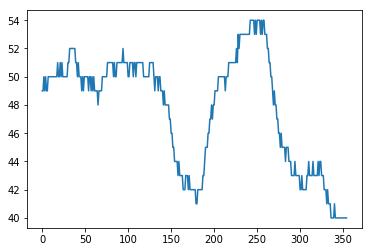

In [93]:
# load the dataset
dataframe = read_csv('train.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

## 数据处理：数据分割

In [0]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

## 数据处理：数据正则化
当激活函数为 sigmoid 或者 tanh 时，要把数据正则化，此时 LSTM 比较敏感 设定 67% 是训练数据，余下的是测试数据

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

## x = t 和 Y = t + 1的数据
维度为[samples,features]

In [0]:
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## 投入到 LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## LSTM
输入一个input，隐藏层4个神经元，输出层就数据一个预测值，激活函数使用sigmoid，迭代20此，batch size设定为1

In [106]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 3s - loss: 0.1012
Epoch 2/20
 - 1s - loss: 0.0141
Epoch 3/20
 - 1s - loss: 0.0061
Epoch 4/20
 - 1s - loss: 0.0030
Epoch 5/20
 - 1s - loss: 0.0022
Epoch 6/20
 - 1s - loss: 0.0022
Epoch 7/20
 - 1s - loss: 0.0023
Epoch 8/20
 - 1s - loss: 0.0023
Epoch 9/20
 - 1s - loss: 0.0022
Epoch 10/20
 - 1s - loss: 0.0021
Epoch 11/20
 - 1s - loss: 0.0023
Epoch 12/20
 - 1s - loss: 0.0023
Epoch 13/20
 - 1s - loss: 0.0022
Epoch 14/20
 - 1s - loss: 0.0022
Epoch 15/20
 - 1s - loss: 0.0024
Epoch 16/20
 - 1s - loss: 0.0022
Epoch 17/20
 - 1s - loss: 0.0022
Epoch 18/20
 - 1s - loss: 0.0023
Epoch 19/20
 - 1s - loss: 0.0022
Epoch 20/20
 - 1s - loss: 0.0022


## 预测

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## 预测测量出误差是多少

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

## 计算出mean squared error

In [109]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.63 RMSE
Test Score: 0.64 RMSE


## 画出结果，蓝色为原来的数据，橙色为训练集的预测值，绿色为测试集的预测值

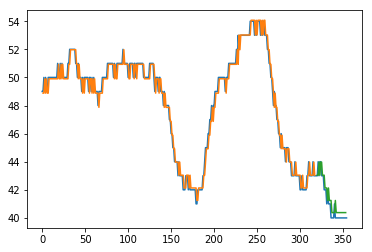

In [110]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
os.chdir("/content/drive/My Drive/LSTM/Different_Models_Score_Pic")
plt.savefig("look_back1_neuron32_dense2.jpg")
plt.show()
os.chdir("/content/drive/My Drive/LSTM")